# A2C Model Training

This code runs A2C model training in two steps. The first step uses watershed labels generated in previous steps. The second step uses labels generated by the first step model (self-learning).

Inputs: 
- A2C images (in .npy format)
- Quality controlled A2C watershed labels
- Self learning labels (in .npy format)

Outputs:
- 1st round A2C Model from watershed labels
- 2nd round A2C Model from self-learning labels

Workflow Steps
1. Import necessary libraries and modules.
2. Load the A2C images and quality controlled A2C watershed labels.
3. Create a data generator for training and validation data.
4. Define the model architecture for the 1st round A2C model.
5. Train the 1st round A2C model using the data generator.
6. Save the trained 1st round A2C model.
7. Generate and load the self-learning labels.
8. Create a new data generator for self-learning data.
9. Define the model architecture for the 2nd round A2C model.
10. Train the 2nd round A2C model using the self-learning data.
11. Save the trained 2nd round A2C model.
12. Run model on training data to see final labels.

<span style="color:red">*Note: The cell that generates self-learning labels is commented out, because the model trained from our small example dataset cannot provide viable labels. Uncomment it after supplying more data.*</span>

In [1]:
import keras
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from utils import util_seg, util_train
from model_arch import unet

Using TensorFlow backend.
2024-08-13 23:29:36.410206: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2024-08-13 23:29:36.410288: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2024-08-13 23:29:36.410294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Load Unet model

In [2]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 32
IMG_CH = 3
N_CHANNELS = 3

model = unet.get_unet(HEIGHT, WIDTH, IMG_CH, N_CHANNELS)

2024-08-13 23:29:37.802399: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-08-13 23:29:37.802431: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-13 23:29:37.802448: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-13-133.us-west-1.compute.internal): /proc/driver/nvidia/version does not exist
2024-08-13 23:29:37.802622: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-08-13 23:29:37.809729: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2024-08-13 23:29:37.810226: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5630bdb70780 initialized for platform Ho

## Load dataframe of images names

In [3]:
label_df = pd.read_csv('example_data/A2C/a2c_watershed_labels_passed_qc.csv')
image_names = label_df['Image'].values

# Normally we would take a subset of the data for early training

# random.shuffle(image_names)
# early_training_images = image_names[:int(len(image_names)*0.3)]

# Randomly take 80% of the data for training and 20% for validation
# random.shuffle(early_training_images)
# X_train = early_training_images[:int(len(early_training_images)*0.8)]
# X_val = early_training_images[int(len(early_training_images)*0.8):]

# Here we have a very small amount of data just for demonstration purposes, so we will take it all
X_train = image_names[:int(len(image_names)*0.8)]
X_val = image_names[int(len(image_names)*0.8):]

size_of_training = len(X_train)
size_of_validation = len(X_val)

print(f"Size of training data: {size_of_training}")
print(f"Size of validation data: {size_of_validation}")

Size of training data: 8
Size of validation data: 2


## Load Data Generator

In [4]:
train_DataGenerator = util_train.DataGenerator(
    list_IDs=X_train,
    labels=X_train,
    path_img='example_data/A2C/a2c_images/',
    path_label='example_data/A2C/a2c_watershed_labels/',
    path_self_learning='example_data/A2C/a2c_step2_labels/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    model=None)

val_DataGenerator = util_train.DataGenerator(
    list_IDs=X_val,
    labels=X_val,
    path_img='example_data/A2C/a2c_images/',
    path_label='example_data/A2C/a2c_watershed_labels/',
    path_self_learning='example_data/A2C/a2c_step2_labels/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    model=None
    )

## Visualize DataGenerator

(32, 256, 256, 3) (32, 256, 256, 3) 1.0 1 float32 uint8
1.0 1


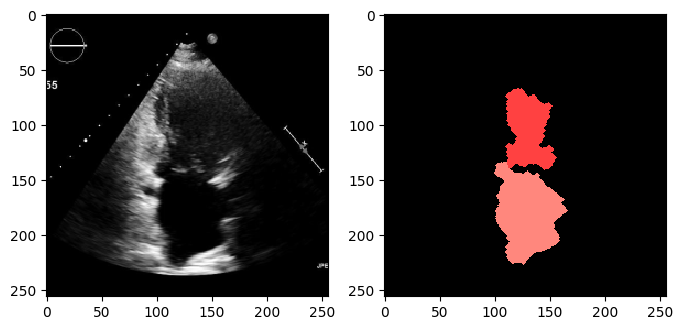

1.0 1


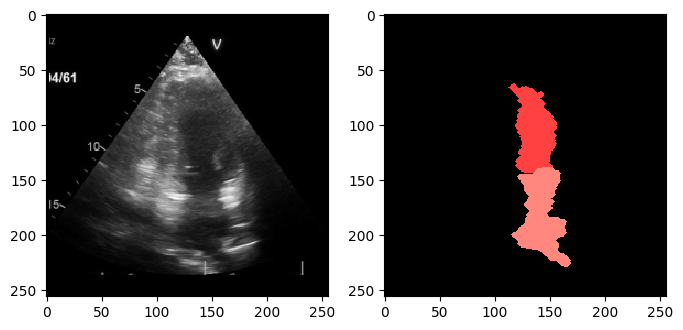

1.0 1


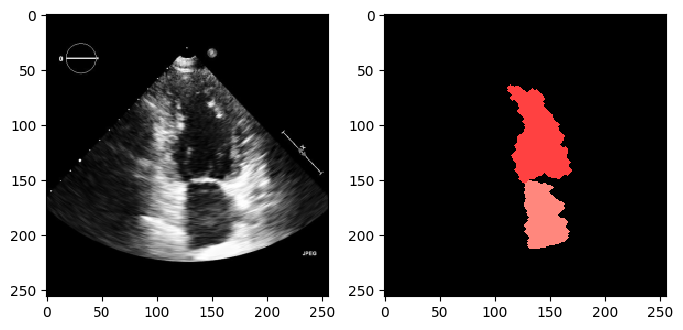

1.0 1


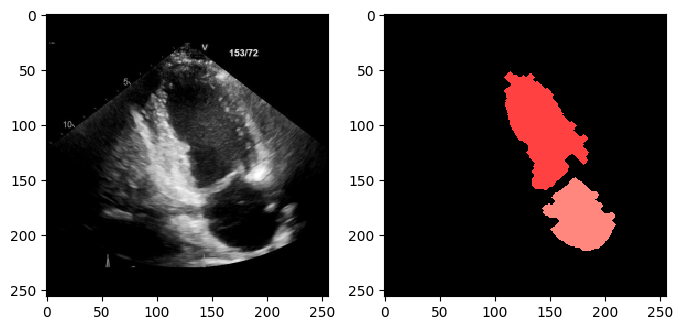

1.0 1


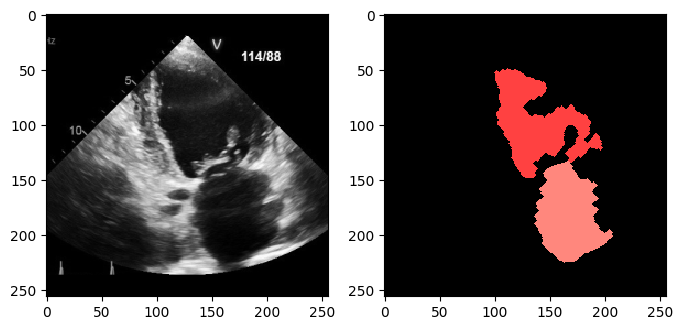

1.0 1


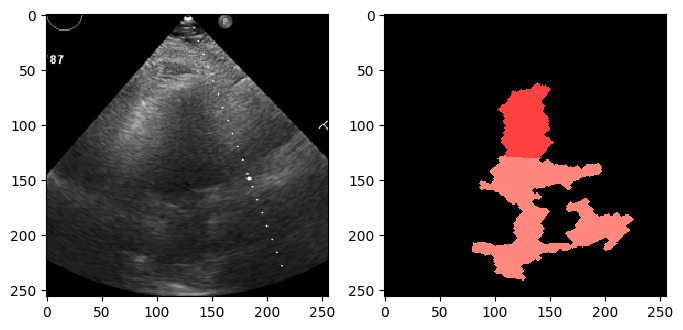

1.0 1


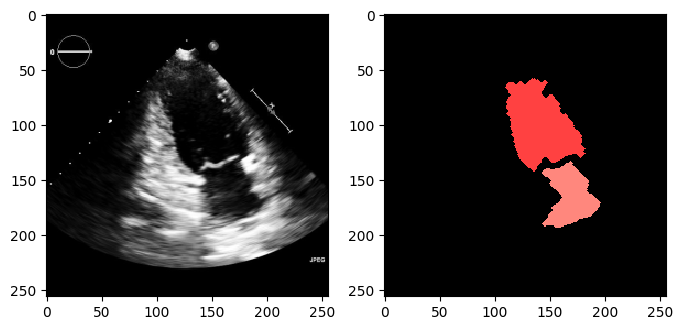

1.0 1


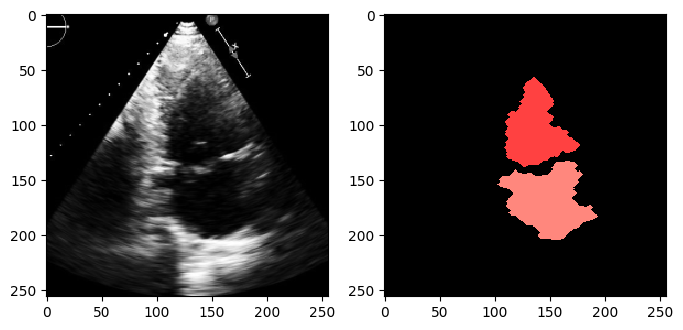

In [5]:
color_list_a2c = [(0,0,0), (255,135,125), (255,65,65)]

x, y = train_DataGenerator.__getitem__(0)
print(x.shape,y.shape,x.max(),y.max(), x.dtype,y.dtype)
for k in range(8):
    print(x[k].max(),y[k].max())
    
    plt.figure(figsize=[8,8])
    plt.subplot(121),plt.imshow(x[k,..., 0], cmap='gray')
    plt.subplot(122),plt.imshow(util_seg.cat_to_color(y[k][np.newaxis], color_list_a2c)[0].astype('uint8'), cmap = 'gray')
    plt.show()

In [6]:
path_w = 'example_model_checkpoints/A2C/1stRound_UNet_A2CModel_{epoch:02d}.h5'

LossHist = util_train.LossHistory()
checkpoint = keras.callbacks.ModelCheckpoint(path_w, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


EPOCHS = 5

hist = model.fit_generator(generator = train_DataGenerator,
                           verbose=0,   # We have to disable prog bar because our validation set is so small, but you can remove this line when using more data to see training progress
                           steps_per_epoch = size_of_training//BATCH_SIZE,
                           validation_data = val_DataGenerator,
                           callbacks=[LossHist,checkpoint],
                           use_multiprocessing = False, 
                           validation_steps = max(1,size_of_validation//BATCH_SIZE), 
                           epochs=EPOCHS, shuffle=True,
                           workers=0)

In [7]:
model.save('example_models/A2C/1stRound_UNet_A2CModel_Example.h5')

## Self Learning Training

In [8]:
# Randomly take 80% of the data for training and 20% for validation
X_train = image_names[:int(len(image_names)*0.8)]
X_val = image_names[int(len(image_names)*0.8):]

size_of_training = len(X_train)
size_of_validation = len(X_val)

print(f"Size of training data: {size_of_training}")
print(f"Size of validation data: {size_of_validation}")

Size of training data: 8
Size of validation data: 2


In [9]:
# Because the a2c model that we just trained was trained on very little data, we use pre-generated labels for self training in this example

# Generate the self learning labels
# path_img = 'example_data/A2C/a2c_images/'
# path_label = 'example_data/A2C/a2c_step2_labels/'
# for ID in image_names:
#     npy_X = np.load(f'{path_img}{ID}')
#     npy_y = model.predict(npy_X[np.newaxis])[0]

#     np.save(f'{path_label}{ID}', npy_y)

In [10]:
train_DataGenerator = util_train.DataGenerator(
    list_IDs=X_train,
    labels=X_train,
    path_img='example_data/A2C/a2c_images/',
    path_label='example_data/A2C/a2c_images_1stround_label/',
    path_self_learning='example_data/A2C/a2c_step2_labels/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    model=model,
    self_learning=True)

val_DataGenerator = util_train.DataGenerator(
    list_IDs=X_val,
    labels=X_val,
    path_img='example_data/A2C/a2c_images/',
    path_label='example_data/A2C/a2c_images_1stround_label/',
    path_self_learning='example_data/A2C/a2c_step2_labels/',
    batch_size=BATCH_SIZE,
    dim=(HEIGHT, WIDTH),
    n_channels=N_CHANNELS,
    shuffle=True,
    model=model,
    self_learning=True)

(32, 256, 256, 3) (32, 256, 256, 3) 1.0 1 float32 uint8
1.0 1


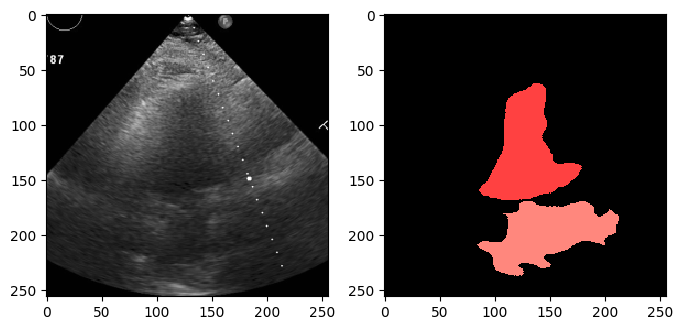

1.0 1


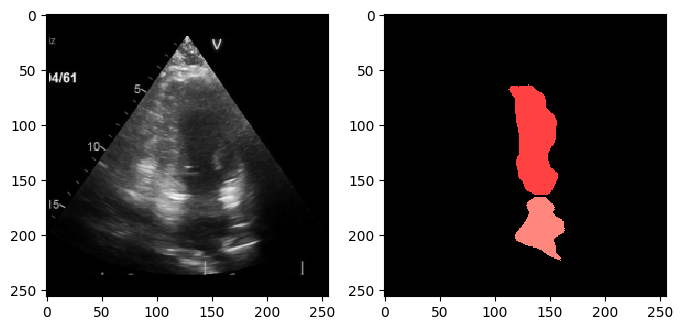

1.0 1


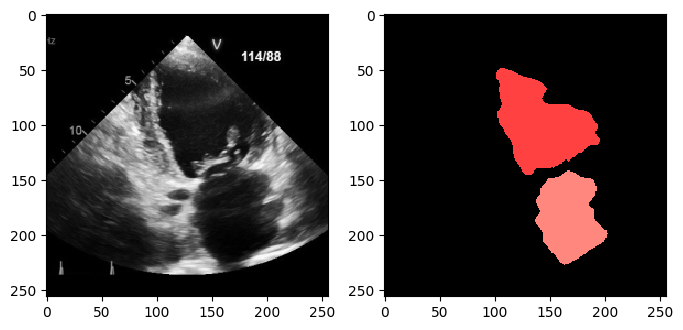

1.0 1


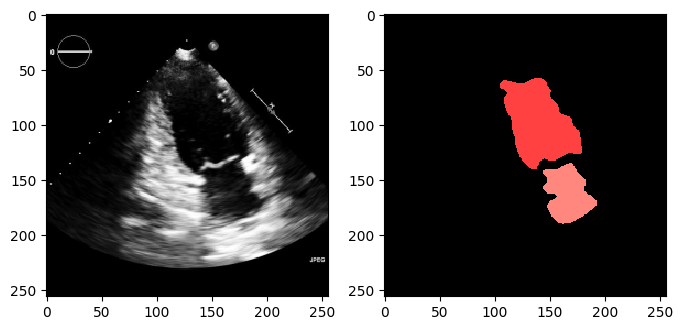

1.0 1


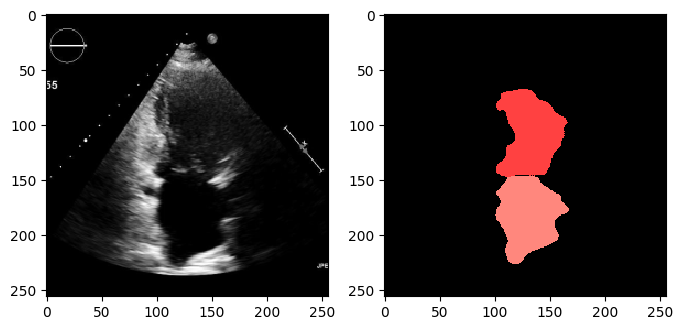

1.0 1


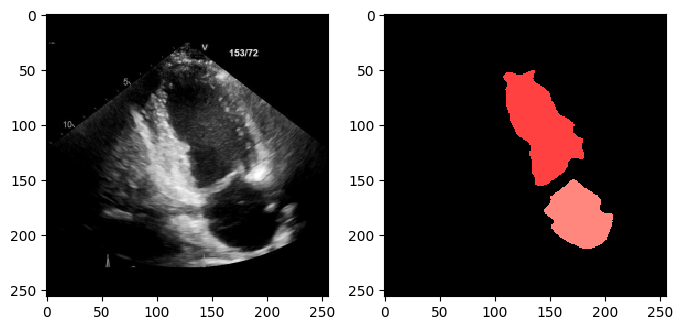

1.0 1


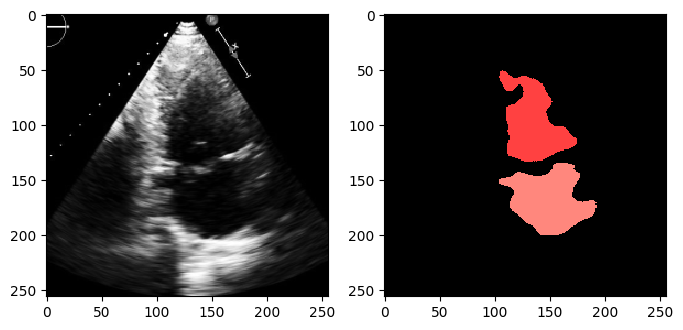

1.0 1


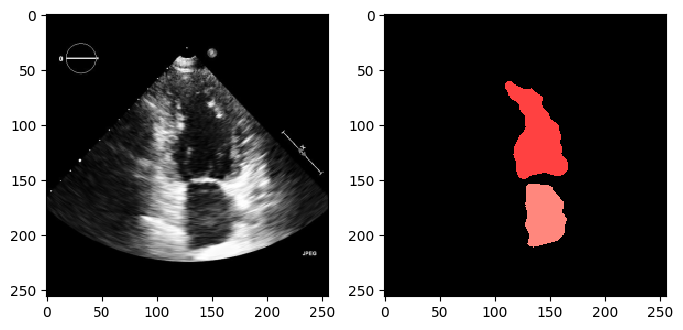

In [11]:
color_list_a2c = [(0,0,0), (255,135,125), (255,65,65)]#, (204,153,255)]

x, y = train_DataGenerator.__getitem__(0)
print(x.shape,y.shape,x.max(),y.max(), x.dtype,y.dtype)
for k in range(8):
    print(x[k].max(),y[k].max())
    
    plt.figure(figsize=[8,8])
    plt.subplot(121),plt.imshow(x[k,..., 0], cmap='gray')
    plt.subplot(122),plt.imshow(util_seg.cat_to_color(y[k][np.newaxis], color_list_a2c)[0].astype('uint8'), cmap = 'gray')
    plt.show()

In [12]:
path_w = 'example_model_checkpoints/A2C/2ndRound_UNet_A2CModel_Self_learning{epoch:02d}.h5'

LossHist = util_train.LossHistory()
checkpoint = keras.callbacks.ModelCheckpoint(path_w, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

EPOCHS = 3

hist = model.fit_generator(generator = train_DataGenerator,
                           verbose=0,   # We have to disable prog bar because our validation set is so small, but you can remove this line when using more data to see training progress
                           steps_per_epoch = size_of_training//BATCH_SIZE,
                           validation_data = val_DataGenerator,
                           callbacks=[LossHist,checkpoint],
                           use_multiprocessing = False, 
                           validation_steps = max(1, size_of_validation//BATCH_SIZE), 
                           epochs=EPOCHS, shuffle=True,
                           workers=0)

In [13]:
model.save('example_models/A2C/2ndRound_UNet_A2CModel_Self_learning_Example.h5')

# Inference

In [14]:
# Because the a2c model that we just trained was trained on very little data, we use pre-generated labels for self training in this example

# Generate the self learning labels
# path_img = 'example_data/A2C/a2c_images/'
# path_label = 'example_data/A2C/a2c_final_inference/'
# if not os.path.exists(path_label):
#     os.makedirs(path_label)

# for ID in image_names:
#     npy_X = np.load(f'{path_img}{ID}')
#     npy_y = model.predict(npy_X[np.newaxis])[0]

#     np.save(f'{path_label}{ID}', npy_y)